# Import

In [1]:
import os 
import datetime as dt
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Data 전처리

In [2]:
data_path = Path(os.getenv('HOME') + '/aiffel/yoochoose/data')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows = None):
    data = pd.read_csv(data_path, sep = '::', header = None, usecols = [0, 1, 2, 3], dtype = {0: np.int32, 1: np.int32, 2: np.int32}, nrows = nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace = True)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [4]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
user_length.mean(), user_length.median()

(165.5975165562914, 96.0)

In [6]:
user_length.min(), user_length.max()

(20, 2314)

In [7]:
user_length.quantile(0.999)

1343.181000000005

In [8]:
long_length = user_length[user_length == 2314].index[0]
data[data['UserId'] == long_length]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [9]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

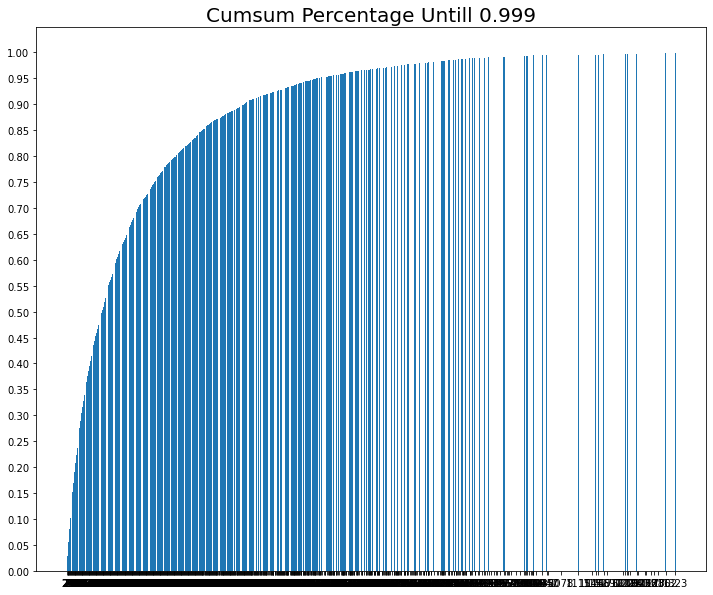

In [10]:
plt.figure(figsize = (12, 10))
plt.bar(x = length_percent_cumsum_999.index, height = length_percent_cumsum_999)
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Untill 0.999', size = 20)
plt.show()

In [11]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

956703932
1046454590


In [12]:
print(datetime.fromtimestamp(oldest).strftime("%Y-%m-%d %H:%M:%S"))
print(datetime.fromtimestamp(latest).strftime("%Y-%m-%d %H:%M:%S"))

2000-04-25 23:05:32
2003-02-28 17:49:50


In [13]:
from datetime import datetime

change_date = []
for time in data['Time']:
    temp = dt.datetime.fromtimestamp(time)
    change_date.append(temp)

data['Time'] = change_date
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


# Cleanse

In [14]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [15]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


# Train/Valid/Test Split

In [16]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    return before_date, after_date

In [17]:
tr, test = split_by_date(data, n_days=180)
tr, val = split_by_date(tr, n_days=180)

In [18]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [19]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 978534
	 Sessions: 6038
	 Items: 3416
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-03-05 04:19:56

* valid Set Stats Info
	 Events: 12271
	 Sessions: 399
	 Items: 2606
	 First Time : 2002-03-05 04:21:07
	 Last Time : 2002-09-01 04:20:59

* test Set Stats Info
	 Events: 8806
	 Sessions: 339
	 Items: 2317
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2003-02-28 17:49:50



In [20]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [21]:
save_path = data_path / 'ex'
save_path.mkdir(parents = True, exist_ok = True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# Data Pipeline

In [22]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [23]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [24]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 978070, 978193, 978534], dtype=int32)

In [25]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6035, 6036, 6037])

In [26]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [27]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size = 4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [28]:
iter_ex = iter(tr_data_loader)

In [29]:
inputs, labels, mask = next(iter_ex)
print(f'Model Input Item Idx are: {inputs}')
print(f'Label Item Idx are: {"":5}{labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are: [ 0 53 65 54]
Label Item Idx are:      [ 1 54 62 24]
Previous Masked Input Idx are []


# Modeling

In [30]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [31]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [32]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20)
args2 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=30)
args3 = Args(tr, val, test, batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=40)

In [33]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout (Dropout)            (256, 50)                 0         
_________________________________________________________________
dense (Dense)                (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [34]:
model2 = create_model(args2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout_1 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


In [35]:
model3 = create_model(args3)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(256, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(256, 50), (256, 50)]    520200    
_________________________________________________________________
dropout_2 (Dropout)          (256, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (256, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


# Model Training

In [37]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

# 1차

In [38]:
train_model(model, args)

Evaluation:  15%|█▌        | 7/46 [00:08<00:46,  1.19s/it]


	 - Recall@20 epoch 1: 0.057478
	 - MRR@20    epoch 1: 0.011833



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.08s/it]


	 - Recall@20 epoch 2: 0.088728
	 - MRR@20    epoch 2: 0.024862



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.08s/it]


	 - Recall@20 epoch 3: 0.094866
	 - MRR@20    epoch 3: 0.026745



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.08s/it]


	 - Recall@20 epoch 4: 0.103795
	 - MRR@20    epoch 4: 0.028800



Evaluation:  15%|█▌        | 7/46 [00:07<00:42,  1.08s/it]

	 - Recall@20 epoch 5: 0.104353
	 - MRR@20    epoch 5: 0.028793



In [39]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:   6%|▌         | 2/33 [00:02<00:33,  1.07s/it]

	 - Recall@20: 0.119141
	 - MRR@20: 0.036655



# 2차

In [40]:
train_model(model2, args2)

Evaluation:  15%|█▌        | 7/46 [00:11<01:02,  1.60s/it]


	 - Recall@30 epoch 1: 0.075335
	 - MRR@30    epoch 1: 0.012444



Evaluation:  15%|█▌        | 7/46 [00:10<01:00,  1.54s/it]


	 - Recall@30 epoch 2: 0.120536
	 - MRR@30    epoch 2: 0.028822



Evaluation:  15%|█▌        | 7/46 [00:10<00:59,  1.51s/it]


	 - Recall@30 epoch 3: 0.130022
	 - MRR@30    epoch 3: 0.031581



Evaluation:  15%|█▌        | 7/46 [00:10<00:58,  1.50s/it]


	 - Recall@30 epoch 4: 0.133371
	 - MRR@30    epoch 4: 0.032422



Evaluation:  15%|█▌        | 7/46 [00:10<00:58,  1.50s/it]


	 - Recall@30 epoch 5: 0.139509
	 - MRR@30    epoch 5: 0.032655



Evaluation:  15%|█▌        | 7/46 [00:10<00:58,  1.51s/it]


	 - Recall@30 epoch 6: 0.137835
	 - MRR@30    epoch 6: 0.032454



Evaluation:  15%|█▌        | 7/46 [00:10<00:59,  1.53s/it]


	 - Recall@30 epoch 7: 0.142299
	 - MRR@30    epoch 7: 0.033017



Evaluation:  15%|█▌        | 7/46 [00:10<00:59,  1.52s/it]


	 - Recall@30 epoch 8: 0.140067
	 - MRR@30    epoch 8: 0.032974



Evaluation:  15%|█▌        | 7/46 [00:10<00:58,  1.50s/it]


	 - Recall@30 epoch 9: 0.140067
	 - MRR@30    epoch 9: 0.032713



Evaluation:  15%|█▌        | 7/46 [00:10<00:58,  1.49s/it]

	 - Recall@30 epoch 10: 0.138951
	 - MRR@30    epoch 10: 0.033901



In [41]:
test_model(model2, args2, test)

Evaluation:   6%|▌         | 2/33 [00:02<00:33,  1.07s/it]

	 - Recall@30: 0.109375
	 - MRR@30: 0.033822



# 3차

In [42]:
train_model(model3, args3)

Evaluation:  15%|█▌        | 7/46 [00:13<01:17,  1.98s/it]


	 - Recall@40 epoch 1: 0.102679
	 - MRR@40    epoch 1: 0.014698



Evaluation:  15%|█▌        | 7/46 [00:13<01:14,  1.91s/it]


	 - Recall@40 epoch 2: 0.140625
	 - MRR@40    epoch 2: 0.025842



Evaluation:  15%|█▌        | 7/46 [00:13<01:15,  1.93s/it]


	 - Recall@40 epoch 3: 0.159598
	 - MRR@40    epoch 3: 0.030452



Evaluation:  15%|█▌        | 7/46 [00:13<01:14,  1.90s/it]


	 - Recall@40 epoch 4: 0.156808
	 - MRR@40    epoch 4: 0.032101



Evaluation:  15%|█▌        | 7/46 [00:13<01:15,  1.93s/it]


	 - Recall@40 epoch 5: 0.162388
	 - MRR@40    epoch 5: 0.033107



Evaluation:  15%|█▌        | 7/46 [00:13<01:15,  1.92s/it]


	 - Recall@40 epoch 6: 0.161830
	 - MRR@40    epoch 6: 0.033208



Evaluation:  15%|█▌        | 7/46 [00:13<01:15,  1.92s/it]


	 - Recall@40 epoch 7: 0.171875
	 - MRR@40    epoch 7: 0.034086



Evaluation:  15%|█▌        | 7/46 [00:13<01:14,  1.91s/it]


	 - Recall@40 epoch 8: 0.168527
	 - MRR@40    epoch 8: 0.035630



Evaluation:  15%|█▌        | 7/46 [00:13<01:13,  1.89s/it]


	 - Recall@40 epoch 9: 0.171875
	 - MRR@40    epoch 9: 0.034580



Evaluation:  15%|█▌        | 7/46 [00:13<01:13,  1.89s/it]


	 - Recall@40 epoch 10: 0.170201
	 - MRR@40    epoch 10: 0.035607



Evaluation:  15%|█▌        | 7/46 [00:13<01:13,  1.89s/it]


	 - Recall@40 epoch 11: 0.169085
	 - MRR@40    epoch 11: 0.035549



Evaluation:  15%|█▌        | 7/46 [00:13<01:13,  1.89s/it]


	 - Recall@40 epoch 12: 0.170201
	 - MRR@40    epoch 12: 0.036393



Evaluation:  15%|█▌        | 7/46 [00:13<01:14,  1.91s/it]


	 - Recall@40 epoch 13: 0.171317
	 - MRR@40    epoch 13: 0.036268



Evaluation:  15%|█▌        | 7/46 [00:13<01:14,  1.91s/it]


	 - Recall@40 epoch 14: 0.169643
	 - MRR@40    epoch 14: 0.035967



Evaluation:  15%|█▌        | 7/46 [00:12<01:12,  1.85s/it]


	 - Recall@40 epoch 15: 0.171317
	 - MRR@40    epoch 15: 0.035969



Evaluation:  15%|█▌        | 7/46 [00:13<01:13,  1.88s/it]


	 - Recall@40 epoch 16: 0.170759
	 - MRR@40    epoch 16: 0.036972



Evaluation:  15%|█▌        | 7/46 [00:13<01:12,  1.87s/it]


	 - Recall@40 epoch 17: 0.167969
	 - MRR@40    epoch 17: 0.035648



Evaluation:  15%|█▌        | 7/46 [00:13<01:13,  1.88s/it]


	 - Recall@40 epoch 18: 0.170201
	 - MRR@40    epoch 18: 0.035765



Evaluation:  15%|█▌        | 7/46 [00:13<01:13,  1.88s/it]


	 - Recall@40 epoch 19: 0.169085
	 - MRR@40    epoch 19: 0.035646



Evaluation:  15%|█▌        | 7/46 [00:13<01:14,  1.91s/it]

	 - Recall@40 epoch 20: 0.167411
	 - MRR@40    epoch 20: 0.035917



In [43]:
test_model(model3, args3, test)

Evaluation:   6%|▌         | 2/33 [00:02<00:32,  1.04s/it]

	 - Recall@40: 0.126953
	 - MRR@40: 0.039966

